### Inversão de circuitos boleanos

### Cifras simétricas

Numa cifra simétrica usa-se a mesma chave secreta para cifrar e decifrar. Uma forma típica de construir uma cifra simétrica consiste em usar a chave como semente num circuito boleano que gera uma sequência pseudo-aleatória de bits, designada *keystream*, que depois é combinada usando gates XOR com o texto em claro, por forma a obter um criptograma. Para decifrar o criptograma e voltar a obter o texto em claro faz-se exactamente o mesmo procedimento. Estas cifras são designadas por *cifras sequenciais*. Mais informação em https://en.wikipedia.org/wiki/Stream_cipher. Toda a segurança destas cifras assenta na dificuldade computacional de inverter o circuito que gera a *keystream*, pois se não fosse esse o caso, se um atacante tivesse acesso ao texto claro correspondente a um criptograma poderia facilmente obter a respectiva chave secreta.

### Salsa20

Uma das cifras simétricas mais populares hoje em dia é o Salsa20 - https://en.wikipedia.org/wiki/Salsa20. Nesta cifra o circuito que gera a *keystream* é constituido por várias iterações de um circuito mais simples designado *quarter-round*, que, dado um vector de 128 bits dividido em 4 inteiros de 32 bits `a`,`b`,`c` e `d`, realiza a seguinte transformação:

```
b = b ^ ((a + d) <<< 7);
c = c ^ ((b + a) <<< 9);
d = d ^ ((c + b) <<< 13);
a = a ^ ((d + c) <<< 18);
```

Nestas transformações `^` representa o XOR bit a bit, `+` a adição módulo 32 e `<<<` é a operação de rotação para a esquerda.

Em Python podemos implementar o circuito *quarter-round* da seguinte forma. A função `qr` aceita uma string de 128 caracteres `0` e `1` e produz como resultado uma destas strings. Desta string são extraídos os 4 inteiros de 32 bits, sobre as quais são realizadas as operações acima referidas. Como os inteiros em Python são de precisão ilimitada, as operações modulares tem que ser implementadas explicitamente. Como o Python também não possui a operação de rotação, a mesma é realizada à custa de operações de shift e da disjunção bit a bit.

In [2]:
# dada uma string de 32 bits ('0' ou '1') devolve o inteiro respectivo
def fromBin(a):
    r = 0
    for i in range(32):
        r = 2*r
        if (a[i]=='1'):
            r = r+1
    return r

# dado um inteiro devolve a string de 32 bits ('0' ou '1') com a sua representação
def toBin(a):
    r = []
    for _ in range(32):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

# função auxiliar que implementa (a+b) <<< n
def ar(a,b,n):
    c = (a+b)%(2**32)
    return ((c << n)%(2**32) | (c >> 32-n))
    
# dada uma string de 128 bits calcula o resultado da operação quarter-round
def qr(v):
    a = fromBin(v[0:32])
    b = fromBin(v[32:64])
    c = fromBin(v[64:96])
    d = fromBin(v[96:128])
    b = b ^ ar(a,d,7)
    c = c ^ ar(b,a,9)
    d = d ^ ar(c,b,13)
    a = a ^ ar(d,c,18)
    return toBin(a)+toBin(b)+toBin(c)+toBin(d)
   
texto = '10'*64
qr(texto)

'11111111111110101000000000100011000000000000000000000000100000001111111111111100111111111111111100001010101001010101010101010101'

Nesta aula vamos usar o Z3 para precisamente tentar inverter esta função, ou seja, dado um valor de output determinar qual o valor de input que dá origem a esse resultado. Em primeiro lugar vamos tentar modelar este problema usando lógica proposicional. Para tal é conveniente perceber como pode ser implementada a função anterior usando directamente sequências de bits em vez de operações sobre inteiros. A função `qr_bs` apresentada a seguir faz essa implementação.

### Exercício 1

Implemente as funções auxiliares `xor32`, `rotate32` e `soma32` que implementam as operações de xor, rotação para a esquerda e soma modular sobre sequências de 32 booleanos.

In [3]:
def xor32(a,b):
    return [a[i] != b[i] for i in range(32)]
    
    
def rotate32(a,n):
    return [a[(n+1)%32] for i in range(32)]  
    

def soma32(b,c):
    carry = False
    x = []
    for i in range(31,-1,-1):
        soma = (b[i] != c[i]) != carry
        carry = [b[i] and c[i] or (carry and (b[i] or c[i]))]
        x.insert(0,soma)
    return x
    

def ar_bs(a,b,n):
    c = soma32(a,b)
    return rotate32(c,n)

def qr_bs(v):
    x = list(map(lambda y: y=='1',v))
    a = x[0:32]
    b = x[32:64]
    c = x[64:96]
    d = x[96:128]
    b = xor32(b,ar_bs(a,d,7))
    c = xor32(c,ar_bs(b,a,9))
    d = xor32(d,ar_bs(c,b,13))
    a = xor32(a,ar_bs(d,c,18))
    r = a+b+c+d
    return ''.join(map(lambda y: '1' if y else '0',r))

texto = '10'*64
qr_bs(texto)

'01010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101'

## Modelação com lógica proposicional

Para inverter a função `qr_bs` usando lógica proposicional podemos começar por criar uma sequência de 128 variáveis proposicionais correspondentes ao input da função, depois "executamos" o *quarter-round* sobre essas variáveis e, finalmente, adicionamos restrições que forçam o output a ser o valor recebido. A função `inv_qr_bs` implementa esta estratégia.

### Exercício 2

Implemente as funções auxiliares `xor32_z3`, `rotate32_z3` e `soma32_z3` que implementam as operações de xor, rotação para a esquerda e soma modular sobre sequências de 32 expressões booleanas do Z3. Relembre o tutorial do Z3Py disponível em https://ericpony.github.io/z3py-tutorial/guide-examples.htm

In [12]:
from z3 import *

def xor32_z3(a,b):
    return [Xor(a[i],b[i]) for i in range(32)]
    
def rotate32_z3(a,n):
    return ((a << n) | LShR(a,32-n))


def soma32_z3(b,c):
    carry = False
    x = []
    for i in range(31,-1,-1):
        soma = Xor(Xor(b[i],c[i]),carry)
        carry = Or((And(b[i],c[i])),And(carry,Or(b[i],c[i])))
        x.insert(0,soma)
    return x
    
def ar_bs_z3(a,b,n):
    c = soma32_z3(a,b)
    return rotate32_z3(c,n)

def inv_qr_bs(v):
    x = [Bool(str(i)) for i in range(128)]
    a = x[0:32]
    b = x[32:64]
    c = x[64:96]
    d = x[96:128]
    b = xor32_z3(b,ar_bs_z3(a,d,7))
    c = xor32_z3(c,ar_bs_z3(b,a,9))
    d = xor32_z3(d,ar_bs_z3(c,b,13))
    a = xor32_z3(a,ar_bs_z3(d,c,18))
    r = a+b+c+d
    s = Solver()
    for i in range(128):
        s.add(r[i] == (v[i]=='1'))
    if s.check() == sat:
        m = s.model()
        return ''.join(['1' if m[x[i]] else '0' for i in range(128)])

texto = '10'*64
inv_qr_bs(qr_bs(texto))

TypeError: unsupported operand type(s) for <<: 'list' and 'int'

## Modelação com SAT módulo teoria de *bit vectors*

A aritmética sobre inteiros de precisão limitada é decidivel. Esta teoria é usalmente conhecida por teoria de *bit vectors* e pode ser utilizada em conjunto com a lógica proposicional em Z3. Com esta teoria podemos tentar inverter directamente a função `qr` apresentada no início deste notebook. A função `inv_qr` definida a seguir implementa essa inversão.

### Exercício 3

Implemente a função auxilar `ar_z3` que implementa a adição modular seguida de uma rotação para a esquerda usando *bit vectors* do Z3.

In [9]:
def ar_z3(a,b,n):
    c = (a+b)
    return ((c << n) | LShR(c,32-n))
    
# função auxiliar que implementa (a+b) <<< n
def ar(a,b,n):
    c = (a+b)%(2**32)
    return ((c << n)%(2**32) | (c >> 32-n))

def inv_qr(v):
    a,b,c,d = BitVecs('a b c d',32)
    b_ = b ^ ar_z3(a,d,7)
    c_ = c ^ ar_z3(b_,a,9)
    d_ = d ^ ar_z3(c_,b_,13)
    a_ = a ^ ar_z3(d_,c_,18)
    s = Solver()
    s.add(a_ == BitVecVal(fromBin(v[0:32]),32))
    s.add(b_ == BitVecVal(fromBin(v[32:64]),32))
    s.add(c_ == BitVecVal(fromBin(v[64:96]),32))
    s.add(d_ == BitVecVal(fromBin(v[96:128]),32))
    if s.check() == sat:
        m = s.model()
        return toBin(m[a].as_long())+toBin(m[b].as_long())+toBin(m[c].as_long())+toBin(m[d].as_long())

texto = '10'*64
inv_qr(qr(texto))

'10101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010'

### Exercício 4

Muitos circuitos boleanos não são funções injectivas, ou seja, podem existir vários valores de input com o mesmo output. Se for usada uma função não injectiva para gerar uma *keystream* a partir da chave, para obter a chave por inversão poderemos necessitar de mais do que um criptograma e do respectivo texto em claro para poder desambiguar qual a chave secreta que está a ser utilizada. Modifique a função anterior para determinar todos os possíveis inputs que podem corresponder à inversão do resultado da função `qr`.

In [10]:
def inv_qr(v):
    a,b,c,d = BitVecs('a b c d',32)
    b_ = b ^ ar_z3(a,d,7)
    c_ = c ^ ar_z3(b_,a,9)
    d_ = d ^ ar_z3(c_,b_,13)
    a_ = a ^ ar_z3(d_,c_,18)
    s = Solver()
    s.add(a_ == BitVecVal(fromBin(v[0:32]),32))
    s.add(b_ == BitVecVal(fromBin(v[32:64]),32))
    s.add(c_ == BitVecVal(fromBin(v[64:96]),32))
    s.add(d_ == BitVecVal(fromBin(v[96:128]),32))
    
    resp = []
    
    while s.check() == sat:
        m = s.model()
        resp.append(toBin(m[a].as_long())+toBin(m[b].as_long())+toBin(m[c].as_long())+toBin(m[d].as_long()))
        s.add(Or(a != m[a], b!=m[b], c!=m[c],d!=m[d]))
    return resp

    
    
texto = '10'*64
inv_qr(qr(texto))

['10101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010']

### Exercício 5

Como deve ter verificado, para o input `'10'*64` não existe mais nenhum input tal que o resultado da função `qr` seja idêntico. Obviamente, isto não quer dizer que a função `qr` seja injectiva, pois poderá existir outro input para o qual haja uma *colisão* dos resultados. Usando o Z3 implemente uma função que testa se a função `qr` é injectiva, ou, caso não seja, apresente um par de inputs diferentes com o mesmo resultado.

In [11]:
def find_colision():
    ax,bx,cx,dx = BitVecs('a b c d',32)
    ay,by,cy,dy = BitVecs('a b c d',32)
    bx_ = bx ^ ar_z3(ax,dx,7)
    cx_ = cx ^ ar_z3(bx_,ax,9)
    dx_ = dx ^ ar_z3(cx_,bx_,13)
    ax_ = ax ^ ar_z3(dx_,cx_,18)
    by_ = by ^ ar_z3(ay,dy,7)
    cy_ = cy ^ ar_z3(by_,ay,9)
    dy_ = dy ^ ar_z3(cy_,by_,13)
    ay_ = ay ^ ar_z3(dy_,cy_,18)
    
    s = Solver()
    s.add(ax_ == ay_)
    s.add(bx_ == by_)
    s.add(cx_ == cy_)
    s.add(dx_ == dy_)
    s.add(Or(ax != ay, bx != by, cx != cy, dx != dy))
    
    if s.check() == sat:
        m = s.model()
        print(toBin(m[ax].as_long())+toBin(m[bx].as_long())+toBin(m[cx].as_long())+toBin(m[dx].as_long()))
        print(toBin(m[ay].as_long())+toBin(m[by].as_long())+toBin(m[cy].as_long())+toBin(m[dy].as_long()))
        
    if s.check() == unsat:
        print("qr é injetiva")
        
find_colision()

qr é injetiva


In [8]:
from networkx import dag_to_branching
from networkx import DiGraph
from networkx import nx
from networkx.utils import arbitrary_element

def circuit_to_formula(circuit):
    # Convert the circuit to an equivalent formula.
    formula = dag_to_branching(circuit)
    # Transfer the operator or variable labels for each node from the
    # circuit to the formula.
    for v in formula:
        source = formula.nodes[v]["source"]
        formula.nodes[v]["label"] = circuit.nodes[source]["label"]
    return formula


def formula_to_string(formula):
    def _to_string(formula, root):
        # If there are no children, this is a variable node.
        label = formula.nodes[root]["label"]
        if not formula[root]:
            return label
        # Otherwise, this is an operator.
        children = formula[root]
        # If one child, the label must be a NOT operator.
        if len(children) == 1:
            child = arbitrary_element(children)
            return f"{label}({_to_string(formula, child)})"
        # NB "left" and "right" here are a little misleading: there is
        # no order on the children of a node. That's okay because the
        # Boolean AND and OR operators are symmetric. It just means that
        # the order of the operands cannot be predicted and hence the
        # function does not necessarily behave the same way on every
        # invocation.
        left, right = formula[root]
        left_subformula = _to_string(formula, left)
        right_subformula = _to_string(formula, right)
        return f"({left_subformula} {label} {right_subformula})"

    root = next(v for v, d in formula.in_degree() if d == 0)
    return _to_string(formula, root)

((x ∨ y) ∧ (y ∨ ¬(z)))


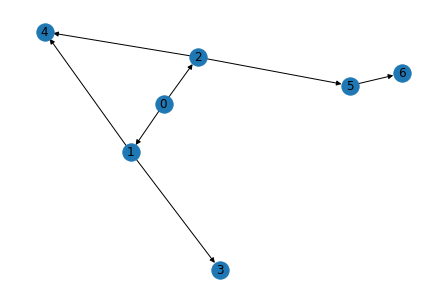

In [12]:

circuit = DiGraph()
# Layer 0
circuit.add_node(0, label="∧")
# Layer 1
circuit.add_node(1, label="∨")
circuit.add_node(2, label="∨")
circuit.add_edge(0, 1)
circuit.add_edge(0, 2)
# Layer 2
circuit.add_node(3, label="x")
circuit.add_node(4, label="y")
circuit.add_node(5, label="¬")
circuit.add_edge(1, 3)
circuit.add_edge(1, 4)
circuit.add_edge(2, 4)
circuit.add_edge(2, 5)
# Layer 3
circuit.add_node(6, label="z")
circuit.add_edge(5, 6)
# Convert the circuit to an equivalent formula.
nx.draw(circuit, with_labels = True)

formula = circuit_to_formula(circuit)
print(formula_to_string(formula))